In [1]:
import torch
from torch import nn
from torchvision import models, transforms

from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px

# images

In [2]:
def preprocess(image_dict: dict) -> dict:
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    procss_images = {}
    for k, v in image_dict.items():
        procss_images[k] = transform(v)
    return procss_images

In [3]:
image_dict = {}
for i in glob("*.jpg"):
    image_dict[i.split(".")[0]] = Image.open(i)
list(image_dict.keys())

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [4]:
image_dict['cat1'].size

(1280, 1280)

In [5]:
procss_images = preprocess(image_dict)
procss_images[list(procss_images.keys())[0]].shape

torch.Size([3, 224, 224])

# models

In [6]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
model = nn.Sequential(*list(resnet50.children())[:-1], nn.Flatten(1))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [8]:
model(torch.zeros(1, 3, 224, 224)).shape

torch.Size([1, 2048])

# run

In [9]:
with torch.inference_mode():
    extracts = model(torch.stack(list(procss_images.values()), dim=0))
extracts.shape

torch.Size([10, 2048])

In [10]:
temp = extracts[:1]
temp.shape

torch.Size([1, 2048])

In [22]:
temp.norm(p=2, dim=-1), temp.square().sum().sqrt()

(tensor([7.4125]), tensor(7.4125))

In [23]:
temp.norm(p=1, dim=-1), temp.abs().sum()

(tensor([76.3710]), tensor(76.3710))

# cosine similarity


[cosine similarity 详细介绍](../01_PyTorch基本/05数学运算/cosine%20similarity.ipynb)

In [13]:
cos_similarity_t = (extracts / extracts.norm(p=2, dim=1, keepdim=True)) @ (extracts / extracts.norm(p=2, dim=1, keepdim=True)).T
cos_similarity_t

tensor([[1.0000, 0.3727, 0.3773, 0.5423, 0.6651, 0.1242, 0.1257, 0.0973, 0.2087,
         0.1879],
        [0.3727, 1.0000, 0.4642, 0.6128, 0.4552, 0.1239, 0.1208, 0.0853, 0.2308,
         0.1629],
        [0.3773, 0.4642, 1.0000, 0.6459, 0.3272, 0.0798, 0.0768, 0.0606, 0.1831,
         0.1024],
        [0.5423, 0.6128, 0.6459, 1.0000, 0.5691, 0.1476, 0.1529, 0.1009, 0.3877,
         0.2121],
        [0.6651, 0.4552, 0.3272, 0.5691, 1.0000, 0.1422, 0.1347, 0.0677, 0.2610,
         0.1893],
        [0.1242, 0.1239, 0.0798, 0.1476, 0.1422, 1.0000, 0.3225, 0.1578, 0.1855,
         0.3027],
        [0.1257, 0.1208, 0.0768, 0.1529, 0.1347, 0.3225, 1.0000, 0.0845, 0.3321,
         0.3312],
        [0.0973, 0.0853, 0.0606, 0.1009, 0.0677, 0.1578, 0.0845, 1.0000, 0.2039,
         0.4856],
        [0.2087, 0.2308, 0.1831, 0.3877, 0.2610, 0.1855, 0.3321, 0.2039, 1.0000,
         0.4496],
        [0.1879, 0.1629, 0.1024, 0.2121, 0.1893, 0.3027, 0.3312, 0.4856, 0.4496,
         1.0000]])

In [14]:
cos_similarity = cos_similarity_t.numpy()

In [15]:
names = list(procss_images.keys())
names

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [16]:
figure = px.imshow(cos_similarity, text_auto=True, x=names, y=names, width=800, height=800, title="cat, dog cos similarity")
figure.show()

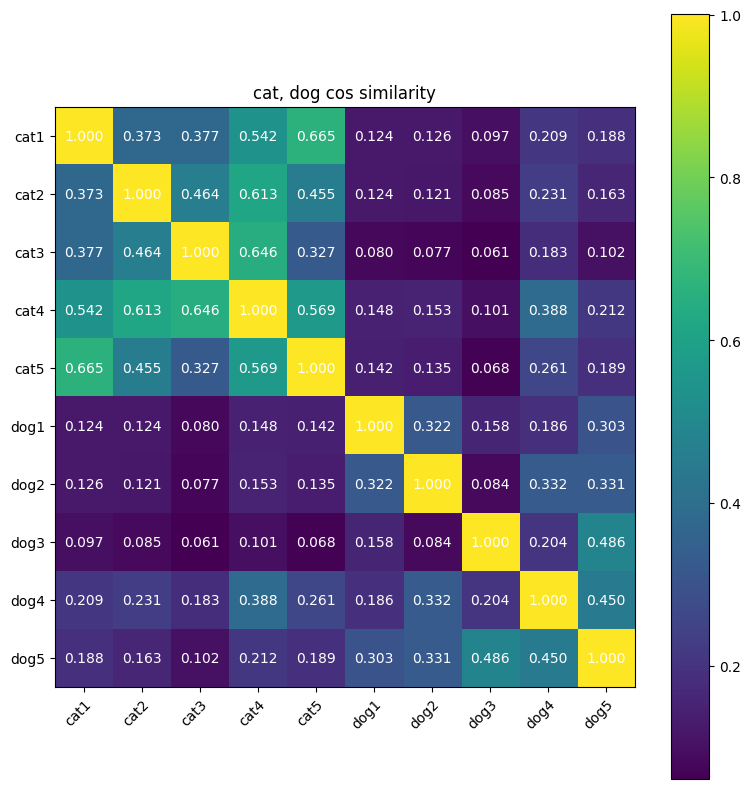

In [17]:
plt.figure(figsize=(8, 8))
plt.xticks(np.arange(len(names)), labels=names, rotation=45, rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(names)), labels=names)
plt.title("cat, dog cos similarity")

# 绘图
plt.imshow(cos_similarity)

# 添加文字
for i in range(len(names)):
    for j in range(len(names)):
        text = plt.text(j, i, "{:.3f}".format(cos_similarity[i, j]), ha="center", va="center", color="w")

plt.colorbar()      # 右侧的条
plt.tight_layout()
plt.show()